# Predictor Validation and Tuning

## Environment Setup

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import time
import matplotlib.pyplot as plt

import json

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import dask.dataframe as dd
import os

def get_dataset_name(M, efC, efS, query_num, ds_name, k, logint):
    return f"/data/mchatzakis/et_training_data/early-stop-training/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{query_num}_li{logint}.txt"

def get_validation_dataset_name(M, efC, efS, query_num, ds_name, k, logint): 
    return f"../../experiments/results/validation_logging/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{query_num}_li{logint}.txt"

def get_model_name(M, ef, s, ds_name, k, logint, selected_features, n_estimators=100):
    return f"../../predictor_models/lightgbm/{ds_name}_M{M}_ef{ef}_s{s}_k{k}_nestim{n_estimators}_li{logint}_{selected_features}.txt"

def compute_P99(y_true, y_pred):
    y_diff = np.abs(y_true - y_pred)
    return np.percentile(y_diff, 99)

def compute_P1(y_true, y_pred):
    y_diff = np.abs(y_true - y_pred)
    return np.percentile(y_diff, 1)

def get_interval_tuning_dataset_name(M, efC, efS, s, ds_name, k, r_target, ipi, mpi, mode="search"):
    return f"../../experiments/results/interval-tuning/{mode}/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{r_target:.2f}_ipi{ipi}_mpi{mpi}.txt"

def get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k):
    return f"../../experiments/results/no-early-stop/validation/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}.txt"

dataset_params = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "li": 1,
            "label": "SIFT100M",
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "li": 1,
            "label": "GIST1M",
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "li": 1,
            "label": "GLOVE1M",
        },
        "DEEP100M":{
            "M": 32,
            "efC": 500,
            "efS": 750,
            "li": 1,
            "label": "DEEP100M",
        },
        "T2I100M":{
            "M": 80,
            "efC": 1000,
            "efS": 2500,
            "li": 2,
            "label": "T2I100M",
        }
    }

SEED = 42

n_estimators = 100

index_metric_feats = ["step", "dists", "inserts"]
neighbor_distances_feats = ["first_nn_dist", "nn_dist", "furthest_dist"]
neighbor_stats_feats = ["avg_dist", "variance", "percentile_25", "percentile_50", "percentile_75"]
all_feats = index_metric_feats + neighbor_distances_feats + neighbor_stats_feats

columns_to_load = ["qid", "elaps_ms"] + all_feats + ["r", "feats_collect_time_ms"]
    
model_conf = {
    "lightgbm": lgb.LGBMRegressor(objective='regression', random_state=SEED, n_estimators=n_estimators, verbose = -1),
}

feature_classes = {
    "index_metric_feats": index_metric_feats,
    "neighbor_distances_feats": neighbor_distances_feats,
    "neighbor_stats_feats": neighbor_stats_feats,
    "index_metrics_and_neighbor_distances": index_metric_feats + neighbor_distances_feats,
    "index_metrics_and_neighbor_stats": index_metric_feats + neighbor_stats_feats,
    "neighbor_distances_and_neighbor_stats": neighbor_distances_feats + neighbor_stats_feats,
    "all_feats": all_feats,
}

print(columns_to_load)

PLOTS_DIR = "./../../experiments/revision-plots/"

['qid', 'elaps_ms', 'step', 'dists', 'inserts', 'first_nn_dist', 'nn_dist', 'furthest_dist', 'avg_dist', 'variance', 'percentile_25', 'percentile_50', 'percentile_75', 'r', 'feats_collect_time_ms']


## Early Termination Opportunities

In [2]:
ds_name = "SIFT100M"
M = dataset_params[ds_name]["M"]
efC = dataset_params[ds_name]["efC"]
efS = dataset_params[ds_name]["efS"]
k=100
li=1

In [3]:
dask_data_all = dd.read_csv(get_dataset_name(M, efC, efS, 10000, ds_name, k, li), usecols=columns_to_load)
data_all = dask_data_all.compute()
print(data_all.shape)

total_queries = 2000
metric = "elaps_ms"

queries = [] # List of [time, recall]
for qid in range(total_queries):
    curr_query = data_all[data_all["qid"] == qid]
    recalls, times = curr_query["r"], curr_query[metric]
    queries.append([times, recalls])

# Define summaries for each query
summarized_queries = []
for times, recalls in queries:
    # Compute mean of times and recalls
    mean_time = np.mean(times)
    mean_recall = np.mean(recalls)
    summarized_queries.append([mean_time, mean_recall])

# Convert summarized queries to a NumPy array
summarized_queries_array = np.array(summarized_queries)

# Normalize the data
scaler = StandardScaler()
normalized_queries = scaler.fit_transform(summarized_queries_array)

# Clustering with 20 clusters
num_queries_to_plot = 4
kmeans = KMeans(n_clusters=num_queries_to_plot, random_state=SEED)
labels = kmeans.fit_predict(normalized_queries)

# Select one query from each cluster
selected_queries = []
for cluster_id in range(num_queries_to_plot):
    cluster_queries = [queries[i] for i in range(len(queries)) if labels[i] == cluster_id]
    selected_queries.append(cluster_queries[0])  # Choose the first query in each cluster

# save selected queries
selected_queries_dict = {}
for i, query in enumerate(selected_queries):
    times, recalls = query
    selected_queries_dict[i] = {"times": times.tolist(), "recalls": recalls.tolist()}

print(selected_queries_dict)

with open(f"../../experiments/generated_json/selected_queries.json", "w") as f:
    json.dump(selected_queries_dict, f)

(159430651, 15)
{0: {'times': [5.881071, 6.128073, 6.369114, 6.614923, 6.854057, 7.091999, 7.333994, 7.580042, 7.82299, 8.068085, 8.307934, 8.554935, 8.793116, 9.031057, 9.284019, 9.536982, 9.783983, 10.035038, 10.2911, 10.548115, 10.793924, 11.039972, 11.301994, 11.550903, 11.800051, 12.04896, 12.303114, 12.552977, 12.798071, 13.04698, 13.309002, 13.567924, 13.842106, 14.104128, 14.367104, 14.619112, 14.868975, 15.115023, 15.372038, 15.61904, 15.876055, 16.139984, 16.405106, 16.658068, 16.91103, 17.169952, 17.431974, 17.68899, 17.942905, 18.196106, 18.465996, 18.723965, 18.976927, 19.234896, 19.500971, 19.757986, 20.020008, 20.281076, 20.55192, 20.817995, 21.076918, 21.342993, 21.610975, 21.87109, 22.133112, 22.404909, 22.677898, 22.937059, 23.199081, 23.462057, 23.730993, 23.992062, 24.257898, 24.526119, 24.794102, 25.057077, 25.326014, 25.590897, 25.862932, 26.132107, 26.39699, 26.660919, 26.932001, 27.19903, 27.482986, 27.758121, 28.021097, 28.288126, 28.554916, 28.820038, 29.08706

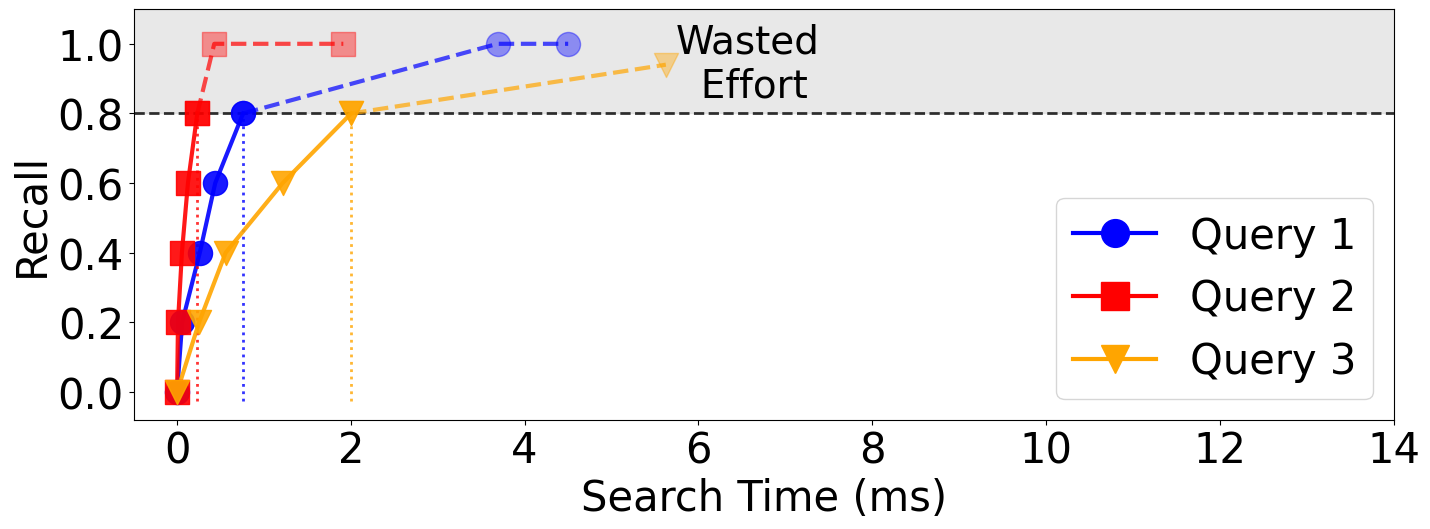

Fig saved at ././../../experiments/revision-plots//early_termination_opportunities_test3.pdf


In [4]:
import matplotlib.pyplot as plt
import json

selected_queries = []
selected_queries_dict = {}
with open(f"../../experiments/generated_json/selected_queries.json", "r") as f:
    selected_queries_dict = json.load(f)

for i in range(len(selected_queries_dict)):
    query = selected_queries_dict[str(i)]
    times, recalls = query["times"], query["recalls"]
    selected_queries.append([times, recalls])

plt.rcParams.update({"font.size": 30})

# Plot the selected queries
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

colors = ["blue", "red", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
markers = ["o", "s", "D", "v", "^", ">", "<", "p", "P", "*"]

# Determine the x-axis limits
max_time = max([max(query[0]) / 1000 for query in selected_queries])

# Fill the background above y=0.8 with light gray
ax.fill_between(
    [-1, 15],  # x-values covering the whole range
    0.8, 1.1,  # y-range for the fill
    color='lightgray', alpha=0.5  # fill color and transparency
)

plt.axhline(y=0.8, color='black', linestyle='--', alpha=0.8, linewidth=2)

query_num = 0
for i, query in enumerate(selected_queries):
    
    times, recalls = query
    times = list(times)
    recalls = list(recalls)
    times = [t / 1000 for t in times]

    if colors[i] == "green":
        continue

    # Find the index where recall reaches 0.8
    index = -1
    for j, r in enumerate(recalls):
        if r >= 0.80:
            plt.axvline(
                x=times[j], color=colors[i], linestyle=":", ymax=r - 0.06, linewidth=2, alpha=0.8, ymin=0.045
            )
            index = j
            break

    # Downsample the data
    downsample_factor = 1200
    downsampled_times = []
    downsampled_recalls = []
    recalls_to_put_markers = [0.2, 0.4, 0.6, 0.8, 1]
    already_found_recalls = [False] * len(recalls_to_put_markers)
    marker_plot_times = []
    marker_plot_recalls = []

    for j, r in enumerate(recalls):
        if r in recalls_to_put_markers and not already_found_recalls[recalls_to_put_markers.index(r)]:
            marker_plot_times.append(times[j])
            marker_plot_recalls.append(r)
            already_found_recalls[recalls_to_put_markers.index(r)] = True
            downsampled_times.append(times[j])
            downsampled_recalls.append(r)
        if j == len(recalls) - 1:
            marker_plot_times.append(times[j])
            marker_plot_recalls.append(r)

    if downsampled_times and downsampled_times[0] != 0:
        downsampled_times.append(times[-1])
        downsampled_recalls.append(recalls[-1])
        downsampled_times.insert(0, 0)
        downsampled_recalls.insert(0, 0)
        marker_plot_times.append(0)
        marker_plot_recalls.append(0)

    # Split the data into before and after recall 0.8
    before_08_times = [t for t, r in zip(downsampled_times, downsampled_recalls) if r <= 0.8]
    before_08_recalls = [r for r in downsampled_recalls if r <= 0.8]
    after_08_times = [t for t, r in zip(downsampled_times, downsampled_recalls) if r >= 0.8]
    after_08_recalls = [r for r in downsampled_recalls if r >= 0.8]

    # Plot the lines with different transparency
    query_num += 1
    ax.plot(before_08_times, before_08_recalls, linestyle="-", alpha=0.9, color=colors[i], linewidth=3)
    ax.plot(after_08_times, after_08_recalls, linestyle="--", alpha=0.7, color=colors[i], linewidth=3)

    # Split the markers
    marker_before_08_times = [t for t, r in zip(marker_plot_times, marker_plot_recalls) if r <= 0.8]
    marker_before_08_recalls = [r for r in marker_plot_recalls if r <= 0.8]
    marker_after_08_times = [t for t, r in zip(marker_plot_times, marker_plot_recalls) if r >= 0.8]
    marker_after_08_recalls = [r for r in marker_plot_recalls if r >= 0.8]

    # Plot the scatter points for recall markers
    ax.scatter(marker_before_08_times, marker_before_08_recalls, color=colors[i], s=300, zorder=5, alpha=0.9, marker=markers[i])
    ax.scatter(marker_after_08_times, marker_after_08_recalls, color=colors[i], s=300, alpha=0.4, marker=markers[i])

    # Add legend for each line including the marker:
    ax.plot([], [], '-', label=f"Query {query_num}", color=colors[i], linewidth=3, marker=markers[i], markersize=20)

#lines_for_legend = [line for line in ax.get_lines() if not line.get_label().startswith('_')]

# Add custom legend for the "Wasted Effort" area
#custom_legend = [plt.Line2D([0], [0], color='lightgray', lw=10, alpha=0.5)]
#ax.legend(custom_legend + lines_for_legend, ['Wasted Effort'] + [line.get_label() for line in lines_for_legend], loc="lower right")
ax.text(max_time * 1.02, 0.85, 'Wasted\n  Effort', fontsize=28, color='black', bbox=dict(facecolor='lightgray', alpha=0.0))

ax.set_xlabel("Search Time (ms)")
ax.set_ylabel("Recall")
ax.legend(loc="lower right") 

#lock x axis to 0-14
ax.set_xlim(-0.5, 14)
ax.set_ylim(-0.08, 1.1)

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

fig.tight_layout()
plt.show()

# Save as PDF
fig.savefig(f"./{PLOTS_DIR}/early_termination_opportunities_test3.pdf", bbox_inches='tight')
print(f"Fig saved at ./{PLOTS_DIR}/early_termination_opportunities_test3.pdf")

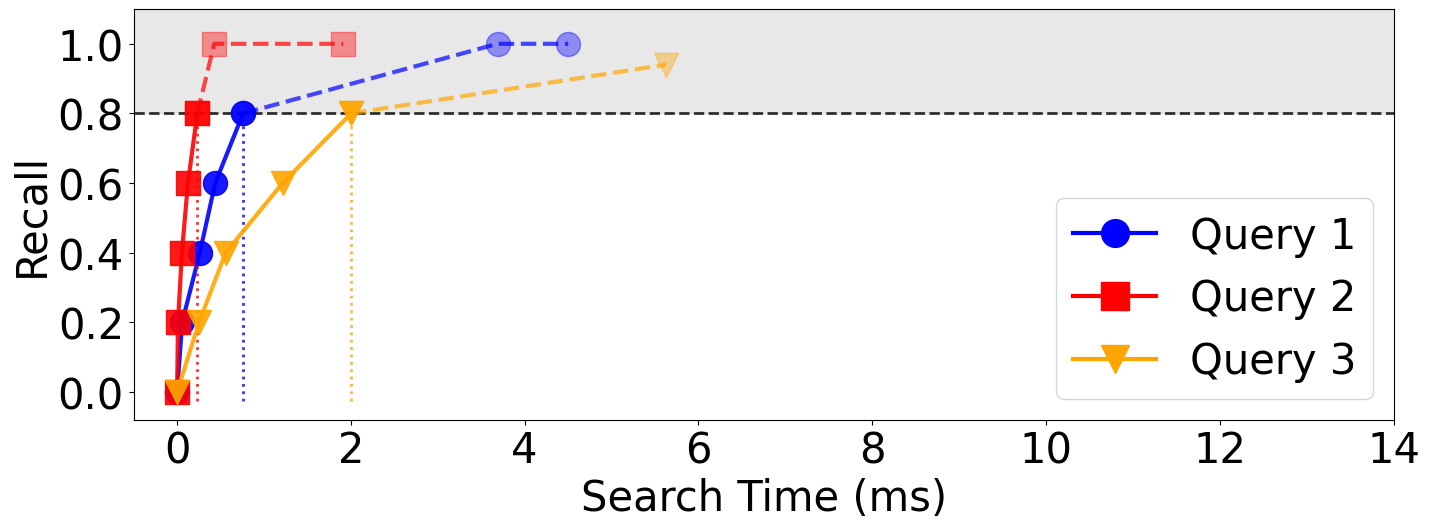

Fig saved at ././../../experiments/revision-plots//early_termination_opportunities_presentation_3.png


In [5]:
import matplotlib.pyplot as plt
import json

selected_queries = []
selected_queries_dict = {}
with open(f"../../experiments/generated_json/selected_queries.json", "r") as f:
    selected_queries_dict = json.load(f)

for i in range(len(selected_queries_dict)):
    query = selected_queries_dict[str(i)]
    times, recalls = query["times"], query["recalls"]
    selected_queries.append([times, recalls])

plt.rcParams.update({"font.size": 30})

# Plot the selected queries
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

colors = ["blue", "red", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
markers = ["o", "s", "D", "v", "^", ">", "<", "p", "P", "*"]

# Determine the x-axis limits
max_time = max([max(query[0]) / 1000 for query in selected_queries])

# Fill the background above y=0.8 with light gray
ax.fill_between(
    [-1, 15],  # x-values covering the whole range
    0.8, 1.1,  # y-range for the fill
    color='lightgray', alpha=0.5  # fill color and transparency
)

plt.axhline(y=0.8, color='black', linestyle='--', alpha=0.8, linewidth=2)

query_num = 0
for i, query in enumerate(selected_queries):
    
    #if (i != 0 and i != 1):
    #    continue
    
    times, recalls = query
    times = list(times)
    recalls = list(recalls)
    times = [t / 1000 for t in times]

    if colors[i] == "green":
        continue

    # Find the index where recall reaches 0.8
    index = -1
    for j, r in enumerate(recalls):
        if r >= 0.80:
            plt.axvline(
                x=times[j], color=colors[i], linestyle=":", ymax=r - 0.06, linewidth=2, alpha=0.8, ymin=0.045
            )
            index = j
            break

    # Downsample the data
    downsample_factor = 1200
    downsampled_times = []
    downsampled_recalls = []
    recalls_to_put_markers = [0.2, 0.4, 0.6, 0.8, 1]
    already_found_recalls = [False] * len(recalls_to_put_markers)
    marker_plot_times = []
    marker_plot_recalls = []

    for j, r in enumerate(recalls):
        if r in recalls_to_put_markers and not already_found_recalls[recalls_to_put_markers.index(r)]:
            marker_plot_times.append(times[j])
            marker_plot_recalls.append(r)
            already_found_recalls[recalls_to_put_markers.index(r)] = True
            downsampled_times.append(times[j])
            downsampled_recalls.append(r)
        if j == len(recalls) - 1:
            marker_plot_times.append(times[j])
            marker_plot_recalls.append(r)

    if downsampled_times and downsampled_times[0] != 0:
        downsampled_times.append(times[-1])
        downsampled_recalls.append(recalls[-1])
        downsampled_times.insert(0, 0)
        downsampled_recalls.insert(0, 0)
        marker_plot_times.append(0)
        marker_plot_recalls.append(0)

    # Split the data into before and after recall 0.8
    before_08_times = [t for t, r in zip(downsampled_times, downsampled_recalls) if r <= 0.8]
    before_08_recalls = [r for r in downsampled_recalls if r <= 0.8]
    after_08_times = [t for t, r in zip(downsampled_times, downsampled_recalls) if r >= 0.8]
    after_08_recalls = [r for r in downsampled_recalls if r >= 0.8]

    # Plot the lines with different transparency
    query_num += 1
    ax.plot(before_08_times, before_08_recalls, linestyle="-", alpha=0.9, color=colors[i], linewidth=3)
    ax.plot(after_08_times, after_08_recalls, linestyle="--", alpha=0.7, color=colors[i], linewidth=3)

    # Split the markers
    marker_before_08_times = [t for t, r in zip(marker_plot_times, marker_plot_recalls) if r <= 0.8]
    marker_before_08_recalls = [r for r in marker_plot_recalls if r <= 0.8]
    marker_after_08_times = [t for t, r in zip(marker_plot_times, marker_plot_recalls) if r >= 0.8]
    marker_after_08_recalls = [r for r in marker_plot_recalls if r >= 0.8]

    # Plot the scatter points for recall markers
    ax.scatter(marker_before_08_times, marker_before_08_recalls, color=colors[i], s=300, zorder=5, alpha=0.9, marker=markers[i])
    ax.scatter(marker_after_08_times, marker_after_08_recalls, color=colors[i], s=300, alpha=0.4, marker=markers[i])

    # Add legend for each line including the marker:
    ax.plot([], [], '-', label=f"Query {query_num}", color=colors[i], linewidth=3, marker=markers[i], markersize=20)

#lines_for_legend = [line for line in ax.get_lines() if not line.get_label().startswith('_')]

# Add custom legend for the "Wasted Effort" area
#custom_legend = [plt.Line2D([0], [0], color='lightgray', lw=10, alpha=0.5)]
#ax.legend(custom_legend + lines_for_legend, ['Wasted Effort'] + [line.get_label() for line in lines_for_legend], loc="lower right")
#ax.text(max_time * 1.02, 0.85, 'Wasted\n  Effort', fontsize=28, color='black', bbox=dict(facecolor='lightgray', alpha=0.0))

ax.set_xlabel("Search Time (ms)")
ax.set_ylabel("Recall")
ax.legend(loc="lower right") 

#lock x axis to 0-14
ax.set_xlim(-0.5, 14)
ax.set_ylim(-0.08, 1.1)

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

fig.tight_layout()
plt.show()

# Save as PDF
fig.savefig(f"./{PLOTS_DIR}/early_termination_opportunities_presentation_3.png")#, bbox_inches='tight')
print(f"Fig saved at ./{PLOTS_DIR}/early_termination_opportunities_presentation_3.png")

## Evaluate the models

In [2]:
results = {}
with open( "../../experiments/generated_json/predictor_validation_results.json", "r") as f:
    results = json.load(f)

all_training_queries = ["10000"]
all_k_values = ["10", "25", "50", "75", "100"]
all_datasets = ["GLOVE100", "SIFT100M", "GIST1M", "DEEP100M"]#, "T2I100M"]
#all_lis = ["1"]
all_metrics = ["r2", "mse", "mae"]
all_feature_types = feature_classes.keys()

best_models = {}

# For every feature class, create a list fo the metrics for each conf
#feature_scores = {}
#for feature_class in all_feature_types:
#    for li in all_lis:
#        feature_scores[f"{feature_class}_{li}"] = {}
#        for metric in all_metrics:
#            feature_scores[f"{feature_class}_{li}"][metric] = []

feature_scores = {}
for feature_class in all_feature_types:
    feature_scores[f"{feature_class}"] = {}
    for metric in all_metrics:
        feature_scores[f"{feature_class}"][metric] = []


#print(feature_scores)

for ds_name in all_datasets:
    best_models[ds_name] = {}
        
    for i, k in enumerate(all_k_values):        
        best_r2 = -1
        best_queries = -1
        best_li = -1
        best_p99 = -1
        best_mse = 1000000
        best_features = ""
        
        for j, metric in enumerate(all_metrics):
            #for li in all_lis:
            for selected_features in all_feature_types:#feature_classes.keys():
                    
                metric_values = [results[ds_name][k][s][li][selected_features][metric] for s in all_training_queries]                    
                queries, metrics = all_training_queries, metric_values
                    
                feature_scores[f"{selected_features}_{li}"][metric].append(metrics)

#print(feature_scores)

# Average the metrics for each feature class
feature_avg_scores = {}
for feature_class in all_feature_types:
    for li in all_lis:
        feature_avg_scores[f"{feature_class}_{li}"] = {}
        for metric in all_metrics:
            feature_avg_scores[f"{feature_class}_{li}"][metric] = np.mean(feature_scores[f"{feature_class}_{li}"][metric])

# Sort by min mse
sorted_feature_avg_scores = {k: v for k, v in sorted(feature_avg_scores.items(), key=lambda item: item[1]["mse"], reverse=False)}
sorted_feature_avg_scores

# Print the first 5
for i, (feature_class, metrics) in enumerate(sorted_feature_avg_scores.items()):
    #if i >= 5:
    #    break

    print(f"{feature_class}")
    for metric in all_metrics:
        if metric == "p99" or metric == "r2" or metric == "" or metric == "mae":
            print(f"    {metric}: {metrics[metric]:.2f}")
        else:
            print(f"    {metric}: {metrics[metric]:.3f}")

# Pick the best feature class and print it
best_feature_class = list(sorted_feature_avg_scores.keys())[0]
best_feature_class

NameError: name 'li' is not defined

In [3]:
results = {}
with open( "../../experiments/generated_json/predictor_validation_results.json", "r") as f:
    results = json.load(f)

all_training_queries = ["10000"]
all_k_values = ["10", "25", "50", "75", "100"]
all_datasets = ["GLOVE100", "SIFT100M", "GIST1M", "DEEP100M"]
all_metrics = ["r2", "mse", "mae"]
all_feature_types = feature_classes.keys()

best_models = {}

feature_scores = {}
for feature_class in all_feature_types:
    feature_scores[f"{feature_class}"] = {}
    for metric in all_metrics:
        feature_scores[f"{feature_class}"][metric] = []


#print(feature_scores)

for ds_name in all_datasets:
    best_models[ds_name] = {}
        
    for i, k in enumerate(all_k_values):        
        best_r2 = -1
        best_queries = -1
        best_li = -1
        best_p99 = -1
        best_mse = 1000000
        best_features = ""
        
        for j, metric in enumerate(all_metrics):
            for selected_features in all_feature_types:
                li = str(dataset_params[ds_name]["li"])
                metric_values = [results[ds_name][k][s][li][selected_features][metric] for s in all_training_queries]                    
                queries, metrics = all_training_queries, metric_values
                    
                feature_scores[f"{selected_features}"][metric].append(metrics)

#print(feature_scores)

# Average the metrics for each feature class
feature_avg_scores = {}
for feature_class in all_feature_types:
    feature_avg_scores[f"{feature_class}"] = {}
    for metric in all_metrics:
        feature_avg_scores[f"{feature_class}"][metric] = np.mean(feature_scores[f"{feature_class}"][metric])

# Sort by min mse
sorted_feature_avg_scores = {k: v for k, v in sorted(feature_avg_scores.items(), key=lambda item: item[1]["mse"], reverse=False)}
sorted_feature_avg_scores

# Print the first 5
for i, (feature_class, metrics) in enumerate(sorted_feature_avg_scores.items()):
    #if i >= 5:
    #    break

    print(f"{feature_class}")
    for metric in all_metrics:
        if metric == "mse" or metric == "mae":
            print(f"    {metric}: {metrics[metric]:.4f}")
        else:
            print(f"    {metric}: {metrics[metric]:.2f}")

# Pick the best feature class and print it
best_feature_class = list(sorted_feature_avg_scores.keys())[0]
best_feature_class

all_feats
    r2: 0.88
    mse: 0.0030
    mae: 0.0269
index_metrics_and_neighbor_stats
    r2: 0.88
    mse: 0.0030
    mae: 0.0269
index_metrics_and_neighbor_distances
    r2: 0.88
    mse: 0.0031
    mae: 0.0275
index_metric_feats
    r2: 0.83
    mse: 0.0043
    mae: 0.0318
neighbor_distances_and_neighbor_stats
    r2: 0.29
    mse: 0.0191
    mae: 0.0798
neighbor_stats_feats
    r2: 0.26
    mse: 0.0201
    mae: 0.0816
neighbor_distances_feats
    r2: 0.22
    mse: 0.0212
    mae: 0.0837


'all_feats'

In [6]:
all_datasets = ["GLOVE100", "SIFT100M", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = ["10", "25", "50", "75", "100"]
best_feature_class = "all_feats"
#best_li = 1
best_s = 10000

for ds_name in all_datasets:
    training_results_dict = {}
    with open(f"../../experiments/generated_json/training_results_{ds_name}.json", "r") as f:
        training_results_dict = json.load(f)
    
    dataset_samples = 0
    dataset_train_time = 0
    
    for k in all_k_values:
        best_li = str(dataset_params[ds_name]["li"])
        training_time = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["training_time"]
        training_samples = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["training_data_size"]
        learning_rate = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["learning_rate"]
        feature_importances = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["feature_importances"]
        
        dataset_samples += training_samples
        dataset_train_time += training_time
    
    dataset_samples = dataset_samples / len(training_results_dict.keys())
    dataset_train_time = dataset_train_time / len(training_results_dict.keys())
    
    print(f"Dataset: {ds_name} => Samples: {dataset_samples:.0f}, Training Time: {dataset_train_time:.0f}s")
        

Dataset: GLOVE100 => Samples: 43700719, Training Time: 84s
Dataset: SIFT100M => Samples: 114221894, Training Time: 87s
Dataset: GIST1M => Samples: 156317181, Training Time: 130s
Dataset: DEEP100M => Samples: 157875441, Training Time: 154s
Dataset: T2I100M => Samples: 342204620, Training Time: 319s


## Feature Importance

In [4]:
best_feature_class = "all_feats"
best_s = 10000
all_datasets = ["GLOVE100", "SIFT100M", "GIST1M", "DEEP100M"]

all_k_values = ["10", "25", "50", "75", "100"]

feature_scores = {}
for ds_name in all_datasets:
    training_results_dict = {}
    with open(f"../../experiments/generated_json/training_results_{ds_name}.json", "r") as f:
        training_results_dict = json.load(f)
    
    for k in training_results_dict.keys():
        #print(training_results_dict[ds_name][k][str(best_s)][str(best_li)][best_feature_class])
        best_li = str(dataset_params[ds_name]["li"])
        training_time = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["training_time"]
        training_samples = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["training_data_size"]
        learning_rate = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["learning_rate"]
        feature_importances = training_results_dict[k][str(best_s)][str(best_li)][best_feature_class]["feature_importances"]
        for entry in feature_importances:
            feature_name = entry["Feature"]
            importance_score = entry["Importance"]
            
            if feature_name not in feature_scores:
                feature_scores[feature_name] = [importance_score]
            else:
                feature_scores[feature_name].append(importance_score)

feature_avg_scores = {}
for feature_name, scores in feature_scores.items():
    feature_avg_scores[feature_name] = np.mean(scores)

sorted_feature_avg_scores = {k: v for k, v in sorted(feature_avg_scores.items(), key=lambda item: item[1], reverse=True)}

#for i, (feature_name, score) in enumerate(sorted_feature_avg_scores.items()):
#    print(f">> {feature_name}: {score:.2f}")
    
# Transform to perc
total_score = sum(feature_avg_scores.values())
perc_feature_avg_scores = {k: v / total_score for k, v in feature_avg_scores.items()}
sorted_perc_feature_avg_scores = {k: v for k, v in sorted(perc_feature_avg_scores.items(), key=lambda item: item[1], reverse=True)}
# Print again:
for i, (feature_name, score) in enumerate(sorted_perc_feature_avg_scores.items()):
    print(f">> {feature_name}: {(score * 100):.0f}%")

>> step: 16%
>> nn_dist: 16%
>> first_nn_dist: 16%
>> inserts: 14%
>> variance: 12%
>> percentile_25: 10%
>> dists: 7%
>> percentile_50: 3%
>> furthest_dist: 3%
>> percentile_75: 2%
>> avg_dist: 2%


## Visualizations for the best models

Saved ./../../experiments/revision-plots/training_queries_legend_only.pdf


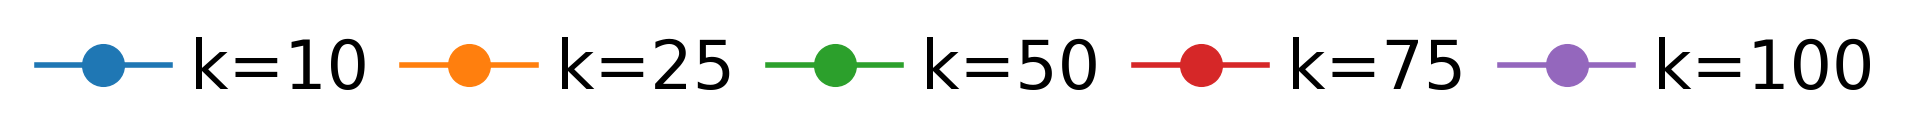

Saved ./../../experiments/revision-plots/training_queries_SIFT100M_mse.pdf


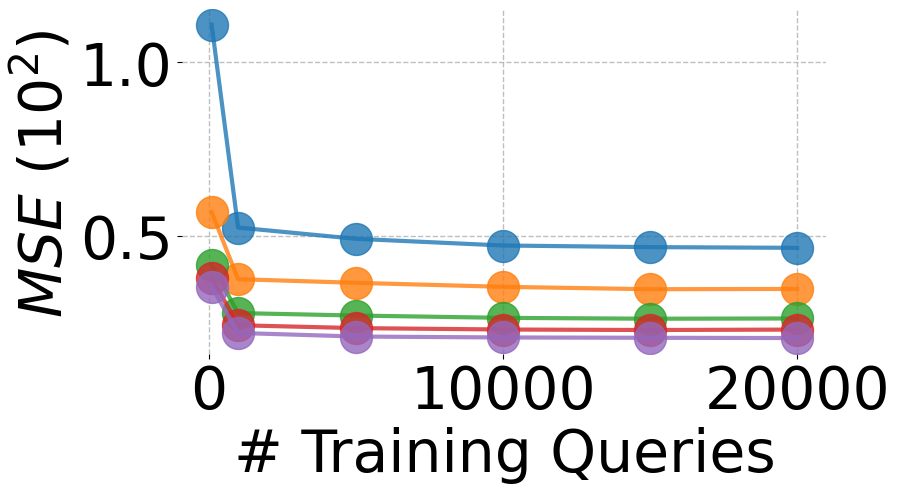

Saved ./../../experiments/revision-plots/training_queries_GLOVE100_mse.pdf


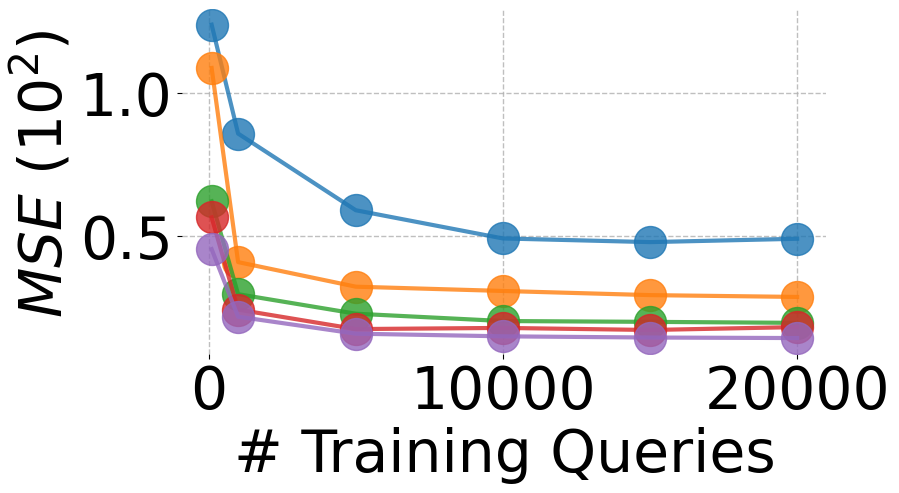

Saved ./../../experiments/revision-plots/training_queries_GIST1M_mse.pdf


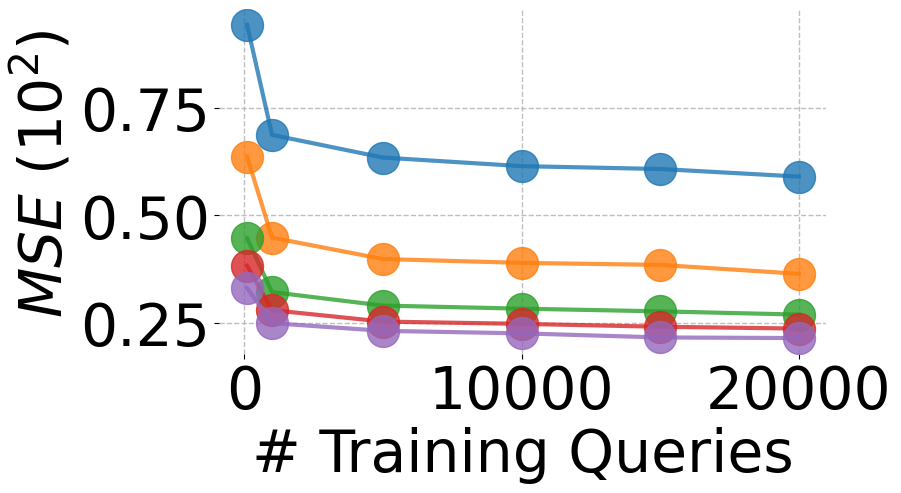

Saved ./../../experiments/revision-plots/training_queries_DEEP100M_mse.pdf


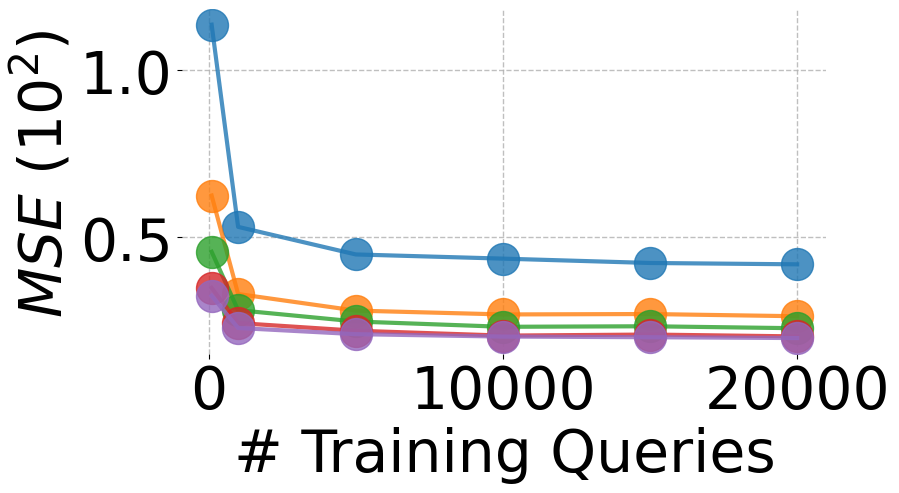

Saved ./../../experiments/revision-plots/training_queries_T2I100M_mse.pdf


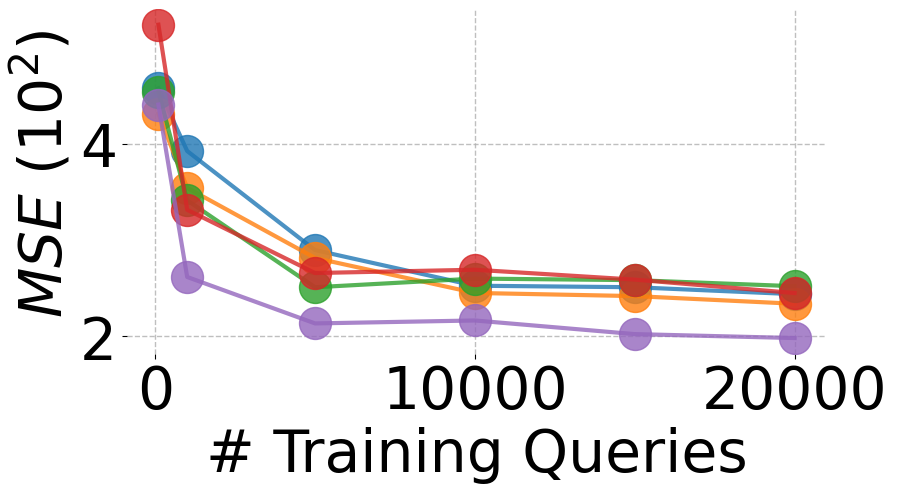

In [5]:
import matplotlib.pyplot as plt
import os

plt.rcParams.update({"font.size": 42})

# Mapping for metric axis titles
metric_axis_titles = {
    "mae": r"$MAE$",
    "mse": r"$MSE$",
    "r2": r"$R^2$",
    "p99": r"$P99$"
}

all_training_queries = ["100", "1000", "5000", "10000", "15000", "20000"]
all_k_values = ["10", "25", "50", "75", "100"]
all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_metrics = ["mse"]#["r2", "mse", "mae"]

#universal_best_li = 1
universal_best_model_features = "all_feats"

# Create a dummy plot for the legend
fig, ax = plt.subplots(figsize=(8, 1))  # Adjust width for a horizontal layout

# Add dummy lines for the legend
for k in all_k_values:
    ax.plot([], [], label=f"k={k}", marker="o", alpha=1, markersize=30, linewidth=4)

legend = ax.legend(
    loc='center', 
    ncol=len(all_k_values), 
    frameon=False,
    fontsize=48,
    handletextpad=0.3,  # Adjust padding between handle and text
    columnspacing=0.5,  # Adjust space between columns
    labelspacing=0.3    # Adjust vertical space between labels
)
ax.axis("off")

# Save the legend figure
legend_fig_path = f"{PLOTS_DIR}training_queries_legend_only.pdf"
fig.savefig(legend_fig_path, format="pdf", bbox_inches="tight")
print(f"Saved {legend_fig_path}")
plt.show()
plt.close(fig)  # Close the figure

# Iterate over datasets and metrics to generate and save figures
for ds_name in all_datasets:
    for metric in all_metrics:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for k in all_k_values:
            best_li = str(dataset_params[ds_name]["li"])
            metric_values = [
                results[ds_name][k][s][str(best_li)][str(universal_best_model_features)][metric] 
                for s in all_training_queries
            ]
            
            if metric == "mse" or metric == "mae":
                metric_values = [v * 100 for v in metric_values]
                ax.set_ylabel(f" {metric_axis_titles[metric]} {r'$(10^{2})$'}")
            else:
                ax.set_ylabel(metric_axis_titles[metric])
                
            ax.plot(
                [int(q) for q in all_training_queries],
                metric_values,
                label=f"k={k}",
                marker="o",
                alpha=0.8,
                linewidth=3,
                markersize=23
            )
            
            for spine in ax.spines.values():
                spine.set_visible(False)
        

        ax.set_xlabel("# Training Queries")
        ax.grid(alpha=0.8, linestyle="--", linewidth=1)
        #ax.tick_params(axis='x', labelsize=44)
        output_path = f"{PLOTS_DIR}training_queries_{ds_name}_{metric}.pdf"
        fig.tight_layout()
        fig.savefig(output_path, format="pdf", bbox_inches="tight")
        if metric == "mse":
            print(f"Saved {output_path}")
            plt.show()
        plt.close(fig)

## Heuristic Parameter Generation for DARTH

### Recommendations for Naive Baseline

In [6]:
# Reccomend the parameters for the early termination naive baseline:
all_datasets =  ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]

for ds_name in all_datasets:
    data_stat_filename = f"../../experiments/generated_json/data_stats_{ds_name}.json"
    data_stats = {}
    with open(data_stat_filename, "r") as f:
        data_stats = json.load(f)
    
    for k in all_k_values:
        
        conf_str = f"{ds_name}_tuples_k{k}=(\n"
        for r_target in all_r_targets:
            avg_dists = data_stats[k]["distance_calcs_to_reach_target_recall"][r_target]["avg"]
            reccomended_stop_point = avg_dists
            conf_str += f"  \"{float(r_target):.2f} {reccomended_stop_point:.0f}\" \n"
        conf_str += ")"
        print(conf_str, "\n")


SIFT100M_tuples_k10=(
  "0.80 1100" 
  "0.85 1564" 
  "0.90 1564" 
  "0.95 2649" 
  "0.99 2649" 
) 

SIFT100M_tuples_k25=(
  "0.80 1479" 
  "0.85 2049" 
  "0.90 2514" 
  "0.95 3247" 
  "0.99 4628" 
) 

SIFT100M_tuples_k50=(
  "0.80 1891" 
  "0.85 2437" 
  "0.90 2979" 
  "0.95 4428" 
  "0.99 6566" 
) 

SIFT100M_tuples_k75=(
  "0.80 2215" 
  "0.85 2780" 
  "0.90 3641" 
  "0.95 5222" 
  "0.99 7670" 
) 

SIFT100M_tuples_k100=(
  "0.80 2491" 
  "0.85 3082" 
  "0.90 3958" 
  "0.95 5453" 
  "0.99 7602" 
) 

GLOVE100_tuples_k10=(
  "0.80 317" 
  "0.85 423" 
  "0.90 423" 
  "0.95 639" 
  "0.99 639" 
) 

GLOVE100_tuples_k25=(
  "0.80 352" 
  "0.85 431" 
  "0.90 492" 
  "0.95 591" 
  "0.99 794" 
) 

GLOVE100_tuples_k50=(
  "0.80 414" 
  "0.85 483" 
  "0.90 543" 
  "0.95 681" 
  "0.99 978" 
) 

GLOVE100_tuples_k75=(
  "0.80 514" 
  "0.85 583" 
  "0.90 674" 
  "0.95 822" 
  "0.99 1172" 
) 

GLOVE100_tuples_k100=(
  "0.80 610" 
  "0.85 691" 
  "0.90 789" 
  "0.95 913" 
  "0.99 1183" 
) 

GIST1M_tupl

### Recommendations for DARTH Heuristic methods (evaluations)

In [7]:
all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = ["50"]
all_r_targets = ["0.90", "0.95", "0.99"]

ipi_div_factors = [2, 4]
mpi_div_factors = [4, 8, 10]

heuristic_recommendations_params = {}
for ipi_div in ipi_div_factors:
    for mpi_div in mpi_div_factors:
        if ipi_div > mpi_div:
            continue
        
        heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"] = {}
        for ds_name in all_datasets:
            heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name] = {}
            data_stat_filename = f"../../experiments/generated_json/data_stats_{ds_name}.json"
            data_stats = {}
            with open(data_stat_filename, "r") as f:
                data_stats = json.load(f)
            
            for k in all_k_values:
                heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][k] = {}
                for r_target in all_r_targets:
                    avg_dists = data_stats[k]["distance_calcs_to_reach_target_recall"][f"{float(r_target):.1f}"]["avg"]
                    reccomended_ipi = avg_dists / ipi_div
                    recommended_mpi = avg_dists / mpi_div
                    heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][k][r_target] = {
                        "ipi": f"{reccomended_ipi:.0f}",
                        "mpi": f"{recommended_mpi:.0f}"
                    }
        
with open(f"../../experiments/generated_json/heuristic_recommendations_params.json", "w") as f:
    json.dump(heuristic_recommendations_params, f, indent=4)

# Print the recommendations in batch format
for ds_name in all_datasets:
    for k in all_k_values:
        conf_str = f"{ds_name}_tuples_k{k}=(\n"
        for r_target in all_r_targets:
            for ipi_div in ipi_div_factors:
                for mpi_div in mpi_div_factors:
                    if ipi_div > mpi_div:
                        continue
                    recommended_ipi = heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][k][r_target]["ipi"]
                    recommended_mpi = heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][k][r_target]["mpi"]
                    conf_str += f"  \"{float(r_target):.2f} {recommended_ipi} {recommended_mpi}\" \n"
        conf_str += ")"
        
        print(conf_str, "\n")

SIFT100M_tuples_k50=(
  "0.90 1489 745" 
  "0.90 1489 372" 
  "0.90 1489 298" 
  "0.90 745 745" 
  "0.90 745 372" 
  "0.90 745 298" 
  "0.95 1489 745" 
  "0.95 1489 372" 
  "0.95 1489 298" 
  "0.95 745 745" 
  "0.95 745 372" 
  "0.95 745 298" 
  "0.99 3283 1641" 
  "0.99 3283 821" 
  "0.99 3283 657" 
  "0.99 1641 1641" 
  "0.99 1641 821" 
  "0.99 1641 657" 
) 

GLOVE100_tuples_k50=(
  "0.90 272 136" 
  "0.90 272 68" 
  "0.90 272 54" 
  "0.90 136 136" 
  "0.90 136 68" 
  "0.90 136 54" 
  "0.95 272 136" 
  "0.95 272 68" 
  "0.95 272 54" 
  "0.95 136 136" 
  "0.95 136 68" 
  "0.95 136 54" 
  "0.99 489 245" 
  "0.99 489 122" 
  "0.99 489 98" 
  "0.99 245 245" 
  "0.99 245 122" 
  "0.99 245 98" 
) 

GIST1M_tuples_k50=(
  "0.90 2145 1072" 
  "0.90 2145 536" 
  "0.90 2145 429" 
  "0.90 1072 1072" 
  "0.90 1072 536" 
  "0.90 1072 429" 
  "0.95 2145 1072" 
  "0.95 2145 536" 
  "0.95 2145 429" 
  "0.95 1072 1072" 
  "0.95 1072 536" 
  "0.95 1072 429" 
  "0.99 4737 2369" 
  "0.99 4737 1184" 
  "0

In [8]:
# Compare here all the versions of the recommendations
heuristic_recommendations_params

accepted_adaptive_heuristic_recommendations = {}
accepted_static_heuristic_recommendations = {}

#mpi_div_factors = [1, 2, 4, 8, 10, 16, 20]
#ipi_div_factors =  [1, 2, 4, 8]
ipi_div_factors = [2, 4]
mpi_div_factors = [4, 8, 10]

all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]
all_k_values = [50]
all_r_targets = ["0.90", "0.99"]

# Calculate the pair of mpi-ipi that has the
mpi_ipi_avg_speedups = {}
for mpi_div in mpi_div_factors:
    for ipi_div in ipi_div_factors:
        if ipi_div > mpi_div:
            continue
        
        ds_speedups = []
        for ds_name in all_datasets:
            M = dataset_params[ds_name]["M"]
            efC = dataset_params[ds_name]["efC"]
            efS = dataset_params[ds_name]["efS"]
            ds_k_speedups = []
            for k in all_k_values:
                ds_k_r_speedups = []
                for r_target in all_r_targets:
                    mpi = heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][str(k)][r_target]["mpi"]
                    ipi = heuristic_recommendations_params[f"{ipi_div}-{mpi_div}"][ds_name][str(k)][r_target]["ipi"]

                    testing_df = pd.read_csv(get_interval_tuning_dataset_name(M, efC, efS, 1000, ds_name, k, float(r_target), ipi, mpi, "heuristics"))
                    testing_df = testing_df[["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",]]
                    
                    baseline_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, 1000, ds_name, k))
                    baseline_df = baseline_df[["qid", "step", "dists", "inserts", "elaps_ms", "r"]]
                    
                    speedup = baseline_df["elaps_ms"].mean() / testing_df["elaps_ms"].mean()
                    
                    ds_k_r_speedups.append(speedup)
                ds_k_speedups.append(np.mean(ds_k_r_speedups))
            ds_speedups.append(np.mean(ds_k_speedups))
        
        mpi_ipi_avg_speedups[f"{ipi_div}-{mpi_div}"] = np.mean(ds_speedups)
                   
# Sort by the mean speedup
sorted_mpi_ipi_avg_speedups = {k: v for k, v in sorted(mpi_ipi_avg_speedups.items(), key=lambda item: item[1], reverse=True)}

# Print all nicely: ipi: XX mpi: XX speedup: XX
for i, (ipi_mpi, speedup) in enumerate(sorted_mpi_ipi_avg_speedups.items()):
    print(f"(ipiDIV_mpiDIV)={ipi_mpi}: {speedup:.2f}x")
        

(ipiDIV_mpiDIV)=2-10: 3.61x
(ipiDIV_mpiDIV)=2-4: 3.57x
(ipiDIV_mpiDIV)=2-8: 3.49x
(ipiDIV_mpiDIV)=4-4: 3.47x
(ipiDIV_mpiDIV)=4-8: 3.46x
(ipiDIV_mpiDIV)=4-10: 3.32x


In [9]:
# Generate the parameters
all_datasets = ["T2I100M", "SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.80", "0.85" ,"0.90", "0.95", "0.99"]

mpi_div_factor = 10
ipi_div_factor = 2

heuristic_recommendations_params = {}
for ds_name in all_datasets:
    heuristic_recommendations_params[ds_name] = {}
    data_stat_filename = f"../../experiments/generated_json/data_stats_{ds_name}.json"
    data_stats = {}
    with open(data_stat_filename, "r") as f:
        data_stats = json.load(f)
    
    for k in all_k_values:
        
        heuristic_recommendations_params[ds_name][k] = {}
        conf_str = f"{ds_name}_tuples_k{k}=(\n"
        for r_target in all_r_targets:
            avg_dists = data_stats[k]["distance_calcs_to_reach_target_recall"][f"{float(r_target):.1f}"]["avg"]
            reccomended_ipi = avg_dists / ipi_div_factor
            recommended_mpi = avg_dists / mpi_div_factor
            conf_str += f"  \"{float(r_target):.2f} {reccomended_ipi:.0f} {recommended_mpi:.0f}\" \n"
            heuristic_recommendations_params[ds_name][k][r_target] = {
                "ipi": f"{reccomended_ipi:.0f}",
                "mpi": f"{recommended_mpi:.0f}"
            }
        
        conf_str += ")"
        print(conf_str, "\n") 

# Save the recommendations to a file
mode = "adaptive"
if mpi_div_factor == ipi_div_factor:
    mode = "static"
with open(f"../../experiments/final_heuristic_{mode}_recommendations_params_ipidiv{ipi_div_factor}_mpidiv{mpi_div_factor}.json", "w") as f:
    json.dump(heuristic_recommendations_params, f, indent=4)
        

T2I100M_tuples_k10=(
  "0.80 2413 483" 
  "0.85 2413 483" 
  "0.90 3246 649" 
  "0.95 3246 649" 
  "0.99 5096 1019" 
) 

T2I100M_tuples_k25=(
  "0.80 2778 556" 
  "0.85 2778 556" 
  "0.90 4416 883" 
  "0.95 4416 883" 
  "0.99 7818 1564" 
) 

T2I100M_tuples_k50=(
  "0.80 3208 642" 
  "0.85 3208 642" 
  "0.90 4766 953" 
  "0.95 4766 953" 
  "0.99 10373 2075" 
) 

T2I100M_tuples_k75=(
  "0.80 3516 703" 
  "0.85 3516 703" 
  "0.90 5527 1105" 
  "0.95 5527 1105" 
  "0.99 11918 2384" 
) 

T2I100M_tuples_k100=(
  "0.80 3742 748" 
  "0.85 3742 748" 
  "0.90 5750 1150" 
  "0.95 5750 1150" 
  "0.99 13070 2614" 
) 

SIFT100M_tuples_k10=(
  "0.80 550 110" 
  "0.85 550 110" 
  "0.90 782 156" 
  "0.95 782 156" 
  "0.99 1325 265" 
) 

SIFT100M_tuples_k25=(
  "0.80 740 148" 
  "0.85 740 148" 
  "0.90 1257 251" 
  "0.95 1257 251" 
  "0.99 2314 463" 
) 

SIFT100M_tuples_k50=(
  "0.80 946 189" 
  "0.85 946 189" 
  "0.90 1489 298" 
  "0.95 1489 298" 
  "0.99 3283 657" 
) 

SIFT100M_tuples_k75=(
  "0.80 11

## Hyperparameter Tuning Comparisons and Ablation Study

In [10]:
# Grid search results
initial_prediction_intervals_normal = [400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
min_prediction_intervals_normal = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]

initial_prediction_intervals_t2i = [400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
min_prediction_intervals_t2i = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]

target_recalls = [0.90, 0.99]
accepted_tuning_confs = {}
best_tuning_confs = {}

all_datasets = ["T2I100M", "SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]
all_k_values = [50]

for ds_name in all_datasets:
    accepted_tuning_confs[ds_name] = {}
    best_tuning_confs[ds_name] = {}
    
    M = dataset_params[ds_name]["M"]
    efC = dataset_params[ds_name]["efC"]
    efS = dataset_params[ds_name]["efS"]
    
    for k in all_k_values:
        best_tuning_confs[ds_name][k] = {
            "r_targets": [],
            "pi_s": []
        }
                
        accepted_tuning_confs[ds_name][k] = {}
        
        for target_recall in target_recalls:            
            best_speedup = 0
            best_mpi = 0
            best_ipi = 0
            best_target_recall = 0
            best_num_queries_under_target_recall = 0
            best_average_predictor_calls = 0
            
            if target_recall == 0.99 and ds_name == "T2I100M":
                target_recall = 0.95
            
            accepted_tuning_confs[ds_name][k][target_recall] = []
            
            #normal_intervals = (initial_prediction_intervals_normal, min_prediction_intervals_normal)
            #t2i_intervals = (initial_prediction_intervals_t2i, min_prediction_intervals_t2i)
            #for intervals in [normal_intervals, t2i_intervals]:
            
            if ds_name == "T2I100M":
                initial_prediction_intervals = initial_prediction_intervals_t2i
                min_prediction_intervals = min_prediction_intervals_t2i
            else:
                initial_prediction_intervals = initial_prediction_intervals_normal
                min_prediction_intervals = min_prediction_intervals_normal
            
            for ipi in initial_prediction_intervals:
                for mpi in min_prediction_intervals:
                    if (ipi < mpi):
                        continue
                                 
                    testing_df = pd.read_csv(get_interval_tuning_dataset_name(M, efC, efS, 1000, ds_name, k, target_recall, ipi, mpi, "search"))
                    testing_df = testing_df[["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",]]
                        
                    baseline_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, 1000, ds_name, k))
                    baseline_df = baseline_df[["qid", "step", "dists", "inserts", "elaps_ms", "r"]]
                        
                    baseline_df = baseline_df[baseline_df["r"] >= float(target_recall)]
                    testing_df = testing_df[testing_df["qid"].isin(baseline_df["qid"])]
                        
                    avg_r_actual = testing_df["r_actual"].mean()
                    speedup = baseline_df["elaps_ms"].mean() / testing_df["elaps_ms"].mean()
                        
                    num_queries_under_target_recall = testing_df[testing_df["r_actual"] < (target_recall - 0.01)].shape[0]
                    average_predictor_calls = testing_df["r_predictor_calls"].mean()
                                            
                    if speedup > best_speedup and avg_r_actual >= target_recall:
                        best_speedup = speedup
                        best_ipi = ipi
                        best_mpi = mpi
                        best_target_recall = avg_r_actual
                        best_num_queries_under_target_recall = num_queries_under_target_recall
                        best_average_predictor_calls = average_predictor_calls
                        
                    if avg_r_actual >= target_recall - 0.01 and speedup >= 1.0:
                        entry = {
                                "speedup": speedup,
                                "ipi": ipi,
                                "mpi": mpi,
                                "recall": avg_r_actual,
                                "rqut": num_queries_under_target_recall,
                                "time": testing_df["elaps_ms"].mean(),
                        }
                        accepted_tuning_confs[ds_name][k][target_recall].append(entry)
                        #else:
                            #print(f"        Discarded tuning conf IPI,MPI: ({ipi},{mpi}) that reached {avg_r_actual:.2f} recall with speedup {speedup:.2f}x")
                        #    pass
                        #results[(ds_name, k)].append((ipi, mpi, avg_r_actual, speedup))
                    
                    
                    
            #print(f"    Rt={target_recall:.2f}: Speedup is {best_speedup:.2f}x with IPI={best_ipi}, MPI={best_mpi}, recall={best_target_recall:.2f}, QUT={best_num_queries_under_target_recall}, AVG Calls={best_average_predictor_calls}")     
            
            best_tuning_confs[ds_name][k]["r_targets"].append(target_recall)
            best_tuning_confs[ds_name][k]["pi_s"].append([best_ipi, best_mpi])
    print()       

sorted_accepted_tuning_confs = {}
for ds_name in accepted_tuning_confs.keys():
    sorted_accepted_tuning_confs[ds_name] = {}
    for k in accepted_tuning_confs[ds_name].keys():
        sorted_accepted_tuning_confs[ds_name][k] = {}
        for target_recall in accepted_tuning_confs[ds_name][k].keys():
            if target_recall == 0.99 and ds_name == "T2I100M":
                target_recall = 0.95
            sorted_accepted_tuning_confs[ds_name][k][target_recall] = sorted(accepted_tuning_confs[ds_name][k][target_recall], key=lambda x: x["speedup"], reverse=True)

DARTH_search_confs = {}
for ds_name in all_datasets:
    DARTH_search_confs[ds_name] = {}
    for k in all_k_values:
        DARTH_search_confs[ds_name][k] = {}
        print(f"{ds_name}, k={k}")
        for target_recall in target_recalls:
            if target_recall == 0.99 and ds_name == "T2I100M":
                target_recall = 0.95
            entry = sorted_accepted_tuning_confs[ds_name][k][target_recall][0]
            DARTH_search_confs[ds_name][k][target_recall] = entry
            print(f"    Rt={target_recall:.2f} => Speedup: {entry['speedup']:.2f}x | IPI: {entry['ipi']} | MPI: {entry['mpi']} | Recall: {entry['recall']:.2f} | QUT: {entry['rqut']}")
            






T2I100M, k=50
    Rt=0.90 => Speedup: 3.48x | IPI: 400 | MPI: 150 | Recall: 0.93 | QUT: 172
    Rt=0.95 => Speedup: 2.19x | IPI: 400 | MPI: 150 | Recall: 0.97 | QUT: 104
SIFT100M, k=50
    Rt=0.90 => Speedup: 5.82x | IPI: 1500 | MPI: 600 | Recall: 0.92 | QUT: 262
    Rt=0.99 => Speedup: 2.18x | IPI: 3500 | MPI: 900 | Recall: 1.00 | QUT: 29
GLOVE100, k=50
    Rt=0.90 => Speedup: 9.51x | IPI: 400 | MPI: 100 | Recall: 0.94 | QUT: 136
    Rt=0.99 => Speedup: 3.65x | IPI: 400 | MPI: 300 | Recall: 1.00 | QUT: 33
GIST1M, k=50
    Rt=0.90 => Speedup: 4.01x | IPI: 2500 | MPI: 750 | Recall: 0.93 | QUT: 193
    Rt=0.99 => Speedup: 1.44x | IPI: 1500 | MPI: 450 | Recall: 1.00 | QUT: 34
DEEP100M, k=50
    Rt=0.90 => Speedup: 4.57x | IPI: 1000 | MPI: 450 | Recall: 0.93 | QUT: 194
    Rt=0.99 => Speedup: 1.70x | IPI: 1500 | MPI: 850 | Recall: 1.00 | QUT: 27


In [11]:
# Calculate recall, speedups etc for the static prediction interval method

all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = [50]
target_recalls = [0.90, 0.99]
prediction_intervals_normal = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
prediction_intervals_t2i = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]

static_prediction_interval_results = {}
for ds_name in all_datasets:
    static_prediction_interval_results[ds_name] = {}
    M = dataset_params[ds_name]["M"]
    efC = dataset_params[ds_name]["efC"]
    efS = dataset_params[ds_name]["efS"]
    for k in all_k_values:
        static_prediction_interval_results[ds_name][k] = {}
        for target_recall in target_recalls:
            if ds_name == "T2I100M" and target_recall == 0.99:
                target_recall = 0.95
            
            static_prediction_interval_results[ds_name][k][target_recall] = []
            
            prediction_intervals = prediction_intervals_normal
            if ds_name == "T2I100M":
                prediction_intervals = prediction_intervals_t2i
            
            for pi in prediction_intervals:
                mpi, ipi = pi, pi
 
                testing_df = pd.read_csv(get_interval_tuning_dataset_name(M, efC, efS, 1000, ds_name, k, target_recall, ipi, mpi, "static"))
                testing_df = testing_df[["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",]]
                    
                baseline_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, 1000, ds_name, k))
                baseline_df = baseline_df[["qid", "step", "dists", "inserts", "elaps_ms", "r"]]
                
                baseline_df = baseline_df[baseline_df["r"] >= float(target_recall)]
                testing_df = testing_df[testing_df["qid"].isin(baseline_df["qid"])]
                    
                avg_r_actual = testing_df["r_actual"].mean()
                speedup = baseline_df["elaps_ms"].mean() / testing_df["elaps_ms"].mean()
                    
                num_queries_under_target_recall = testing_df[testing_df["r_actual"] < (target_recall - 0.01)].shape[0]
                average_predictor_calls = testing_df["r_predictor_calls"].mean()
                    
                if avg_r_actual >= target_recall - 0.01:
                    entry = {
                        "speedup": speedup,
                        "ipi": ipi,
                        "mpi": mpi,
                        "recall": avg_r_actual,
                        "rqut": num_queries_under_target_recall,
                        "time": testing_df["elaps_ms"].mean()
                    }
                    static_prediction_interval_results[ds_name][k][target_recall].append(entry)

# Sort the results
sorted_static_prediction_interval_results = {}
for ds_name in static_prediction_interval_results.keys():
    sorted_static_prediction_interval_results[ds_name] = {}
    for k in static_prediction_interval_results[ds_name].keys():
        sorted_static_prediction_interval_results[ds_name][k] = {}
        for target_recall in static_prediction_interval_results[ds_name][k].keys():
            if ds_name == "T2I100M" and target_recall == 0.99:
                target_recall = 0.95
            sorted_static_prediction_interval_results[ds_name][k][target_recall] = sorted(static_prediction_interval_results[ds_name][k][target_recall], key=lambda x: x["speedup"], reverse=True)
                    
# Print the best results
DARTH_static_confs = {}
for ds_name in all_datasets:
    for k in all_k_values:
        print(f"{ds_name}, k={k}")
        for target_recall in target_recalls:
            if ds_name == "T2I100M" and target_recall == 0.99:
                target_recall = 0.95
            entry = sorted_static_prediction_interval_results[ds_name][k][target_recall][0]
            print(f"    Rt={target_recall:.2f} => Speedup: {entry['speedup']:.2f}x | IPI: {entry['ipi']} | MPI: {entry['mpi']} | Recall: {entry['recall']:.2f} | QUT: {entry['rqut']}")
            DARTH_static_confs[(ds_name, k, target_recall)] = entry


SIFT100M, k=50
    Rt=0.90 => Speedup: 5.65x | IPI: 600 | MPI: 600 | Recall: 0.92 | QUT: 253
    Rt=0.99 => Speedup: 2.14x | IPI: 700 | MPI: 700 | Recall: 1.00 | QUT: 32
GLOVE100, k=50
    Rt=0.90 => Speedup: 8.45x | IPI: 200 | MPI: 200 | Recall: 0.95 | QUT: 115
    Rt=0.99 => Speedup: 3.51x | IPI: 400 | MPI: 400 | Recall: 1.00 | QUT: 31
GIST1M, k=50
    Rt=0.90 => Speedup: 4.22x | IPI: 300 | MPI: 300 | Recall: 0.92 | QUT: 261
    Rt=0.99 => Speedup: 1.43x | IPI: 600 | MPI: 600 | Recall: 1.00 | QUT: 33
DEEP100M, k=50
    Rt=0.90 => Speedup: 4.48x | IPI: 600 | MPI: 600 | Recall: 0.93 | QUT: 182
    Rt=0.99 => Speedup: 1.71x | IPI: 1000 | MPI: 1000 | Recall: 1.00 | QUT: 25
T2I100M, k=50
    Rt=0.90 => Speedup: 3.66x | IPI: 2000 | MPI: 2000 | Recall: 0.95 | QUT: 133
    Rt=0.95 => Speedup: 2.04x | IPI: 1000 | MPI: 1000 | Recall: 0.97 | QUT: 95


In [12]:
# Get the resutls ffrom the heuristic recommendations
DARTH_heuristic_adaptive_confs = {}
DARTH_heuristic_static_confs = {}

heuristic_adaptive_filename = "../../experiments/generated_json/final_heuristic_adaptive_recommendations_params_ipidiv2_mpidiv10.json"
heuristic_static_filename = "../../experiments/generated_json/final_heuristic_static_recommendations_params_ipidiv4_mpidiv4.json"

all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = [50]
target_recalls = [0.90, 0.99]

confs = [DARTH_heuristic_adaptive_confs, DARTH_heuristic_static_confs]
filenames = [heuristic_adaptive_filename, heuristic_static_filename]
modes = ["adaptive", "static"]

for DARTH_conf, filename, mode in zip(confs, filenames, modes):
    heuristic_recommendations_params = {}
    with open(filename, "r") as f:
        heuristic_recommendations_params = json.load(f)

    print(f"Processing {mode} recommendations")
    
    for ds_name in all_datasets:
        DARTH_conf[ds_name] = {}
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        for k in all_k_values:
            print(f"    {ds_name}, k={k}")
            DARTH_conf[ds_name][k] = {}
            for target_recall in target_recalls:
                if ds_name == "T2I100M" and target_recall == 0.99:
                    target_recall = 0.95
                
                mpi = heuristic_recommendations_params[ds_name][str(k)][str(f"{float(target_recall):.2f}")]["mpi"]
                ipi = heuristic_recommendations_params[ds_name][str(k)][str(f"{float(target_recall):.2f}")]["ipi"]
                
                print(f"        Rt={target_recall:.2f} => IPI: {ipi} | MPI: {mpi}")
                
                testing_df = pd.read_csv(get_interval_tuning_dataset_name(M, efC, efS, 1000, ds_name, k, target_recall, ipi, mpi, "heuristics"))
                testing_df = testing_df[["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",]]
                
                baseline_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, 1000, ds_name, k))
                baseline_df = baseline_df[["qid", "step", "dists", "inserts", "elaps_ms", "r"]]
                
                baseline_df = baseline_df[baseline_df["r"] >= float(target_recall)]
                testing_df = testing_df[testing_df["qid"].isin(baseline_df["qid"])]
                
                avg_r_actual = testing_df["r_actual"].mean()
                speedup = baseline_df["elaps_ms"].mean() / testing_df["elaps_ms"].mean()
                
                num_queries_under_target_recall = testing_df[testing_df["r_actual"] < (target_recall - 0.01)].shape[0]
                average_predictor_calls = testing_df["r_predictor_calls"].mean()
                                
                DARTH_conf[ds_name][k][target_recall] = {
                    "speedup": speedup,
                    "ipi": int(ipi),
                    "mpi": int(mpi),
                    "recall": avg_r_actual,
                    "rqut": num_queries_under_target_recall,
                    "time": testing_df["elaps_ms"].mean()
                }

Processing adaptive recommendations
    SIFT100M, k=50
        Rt=0.90 => IPI: 1489 | MPI: 298
        Rt=0.99 => IPI: 3283 | MPI: 657
    GLOVE100, k=50
        Rt=0.90 => IPI: 272 | MPI: 54
        Rt=0.99 => IPI: 489 | MPI: 98
    GIST1M, k=50
        Rt=0.90 => IPI: 2145 | MPI: 429
        Rt=0.99 => IPI: 4737 | MPI: 947
    DEEP100M, k=50
        Rt=0.90 => IPI: 1819 | MPI: 364
        Rt=0.99 => IPI: 4011 | MPI: 802
    T2I100M, k=50
        Rt=0.90 => IPI: 4766 | MPI: 953
        Rt=0.95 => IPI: 4766 | MPI: 953
Processing static recommendations
    SIFT100M, k=50
        Rt=0.90 => IPI: 745 | MPI: 745
        Rt=0.99 => IPI: 1641 | MPI: 1641
    GLOVE100, k=50
        Rt=0.90 => IPI: 136 | MPI: 136
        Rt=0.99 => IPI: 245 | MPI: 245
    GIST1M, k=50
        Rt=0.90 => IPI: 1072 | MPI: 1072
        Rt=0.99 => IPI: 2369 | MPI: 2369
    DEEP100M, k=50
        Rt=0.90 => IPI: 910 | MPI: 910
        Rt=0.99 => IPI: 2005 | MPI: 2005
    T2I100M, k=50
        Rt=0.90 => IPI: 2383 |

In [13]:
DARTH_heuristic_adaptive_confs["T2I100M"][k][0.95]

{'speedup': 2.233712912436456,
 'ipi': 4766,
 'mpi': 953,
 'recall': 0.9733117583603021,
 'rqut': 90,
 'time': 52.908526261057176}

Saved plot at ./../../experiments/revision-plots/interval_ablation_speedup_k50_rt0.90.pdf


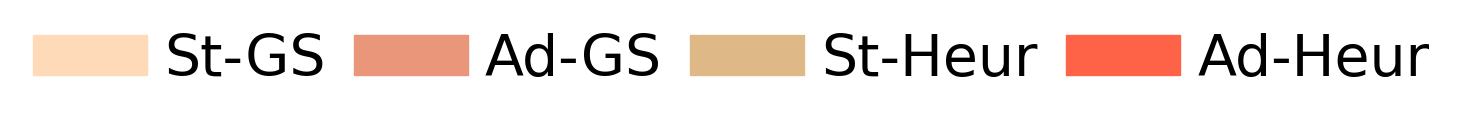

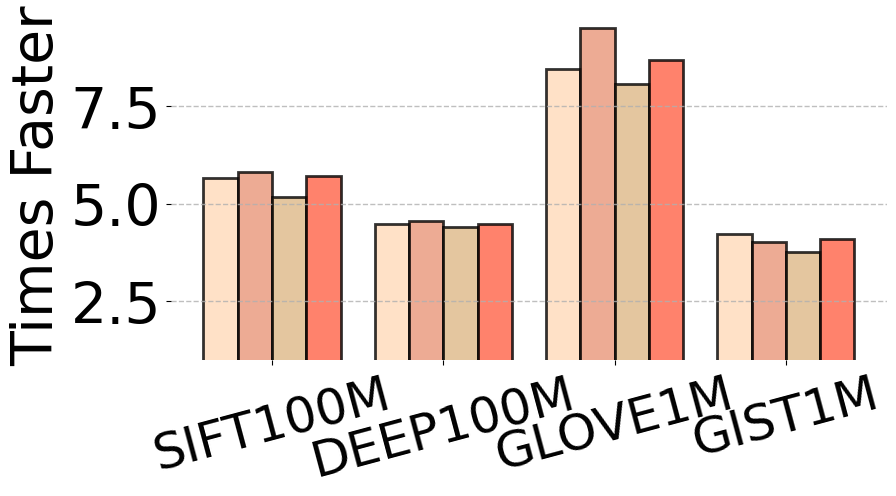

Saved plot at ./../../experiments/revision-plots/interval_ablation_speedup_k50_rt0.99.pdf


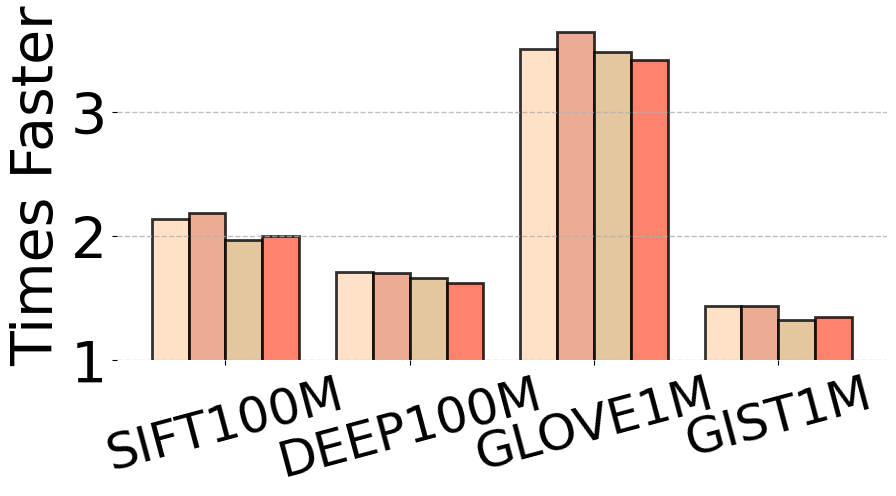

Average speedup of Grid-Search Adaptive over Heuristic Adaptive: 1.05x
Average speedup of Grid-Search Adaptive over Static: 1.08x
Average speedup of Heuristic Adaptive over Static Heuristic: 1.03x
Max speedup of Grid-Search Adaptive over Static: 1.13x
Max speedup of Heuristic Adaptive over Static: 1.10x


In [19]:
from matplotlib.patches import Patch

all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = [50]

algos = {
    "Static-Grid-Search": {
        "color": "peachpuff",
    },
    "Adaptive-Grid-Search": {
        "color": "darksalmon",
    },
    "Static-Heuristic": {
        "color": "burlywood",
    },
    "Adaptive-Heuristic": {
        "color": "tomato",
    }
}

plt.rcParams.update({"font.size": 41})

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))  # Adjust the figsize for better alignment
legend_elements = [
    Patch(facecolor=algos["Static-Grid-Search"]["color"], edgecolor=algos["Static-Grid-Search"]["color"], label="St-GS"),
    Patch(facecolor=algos["Adaptive-Grid-Search"]["color"], edgecolor=algos["Adaptive-Grid-Search"]["color"], label="Ad-GS"),
    Patch(facecolor=algos["Static-Heuristic"]["color"], edgecolor=algos["Static-Heuristic"]["color"], label="St-Heur"),
    Patch(facecolor=algos["Adaptive-Heuristic"]["color"], edgecolor=algos["Adaptive-Heuristic"]["color"], label="Ad-Heur"),
]
#ax_legend.legend(handles=legend_elements, loc='center', ncol=4, frameon=False)
ax_legend.legend(
    handles=legend_elements, 
    loc='center', 
    ncol=4, 
    frameon=False,
    handletextpad=0.3,  # Adjust padding between handle and text
    columnspacing=0.5,  # Adjust space between columns
    labelspacing=0.3    # Adjust vertical space between labels
)
ax_legend.axis('off')
fig_legend.savefig(f"{PLOTS_DIR}interval_ablation_legend_only.pdf", bbox_inches="tight")


#plt.rcParams.update({"font.size": 36})  

measures = {
    "speedup": {
        "title": "Speedup",
        "label": "Times Faster",
        "y-bottom-lim": 1
    },
    #"time": {
    #    "title": "Time",
    #    "label": "Search Time (ms)",
    #    "y-bottom-lim": 0
    #}
    #"rqut": {
    #    "title": "Queries% Under Target Recall",
    #    "label": "RQUT",
    #    "y-bottom-lim": 0
    #    
    #}
}

#change colors
target_recalls = [0.90, 0.99]

# Calculate also the average speedup of grid search adaptive to compare with the heuristic adaptive
avg_speedup_grid_search_adaptive_over_heuristic = 0
avg_speedup_grid_search_adaptive_over_static = 0
avg_speedup_heuristic_adaptive_over_static_heuristic = 0
speedup_nums = 0

max_speedup_grid_search_adaptive_over_static = 0
max_speedup_heuristic_adaptive_over_static = 0

for k in all_k_values:
    for i, target_recall in enumerate(target_recalls):
        for measure, measure_info in measures.items():
            DARTH_heuristic_adaptive = []#[DARTH_heuristic_adaptive_confs[ds_name][k][target_recall][measure] for ds_name in all_datasets]
            DARTH_heuristic_static = []#[DARTH_heuristic_static_confs[ds_name][k][target_recall][measure] for ds_name in all_datasets]
            DARTH_grid_search_adaptive = []#[DARTH_search_confs[ds_name][k][target_recall][measure] for ds_name in all_datasets]
            DARTH_grid_search_static = []#[DARTH_static_confs[(ds_name, k, target_recall)][measure] for ds_name in all_datasets]
            for ds_name in all_datasets:
                prev_recall = target_recall
                if ds_name == "T2I100M" and target_recall == 0.99:
                    target_recall = 0.95
                
                DARTH_heuristic_adaptive.append(DARTH_heuristic_adaptive_confs[ds_name][k][target_recall][measure])
                DARTH_heuristic_static.append(DARTH_heuristic_static_confs[ds_name][k][target_recall][measure])
                DARTH_grid_search_adaptive.append(DARTH_search_confs[ds_name][k][target_recall][measure])
                DARTH_grid_search_static.append(DARTH_static_confs[(ds_name, k, target_recall)][measure])

                time_heuristic_adaptive = DARTH_heuristic_adaptive_confs[ds_name][k][target_recall]["time"]
                time_grid_search_adaptive = DARTH_search_confs[ds_name][k][target_recall]["time"]
                time_heuristic_static = DARTH_heuristic_static_confs[ds_name][k][target_recall]["time"]
                time_grid_search_static = DARTH_static_confs[(ds_name, k, target_recall)]["time"]
                
                avg_speedup_grid_search_adaptive_over_heuristic += time_heuristic_adaptive / time_grid_search_adaptive
                avg_speedup_grid_search_adaptive_over_static += time_heuristic_static / time_grid_search_adaptive
                avg_speedup_heuristic_adaptive_over_static_heuristic += time_heuristic_static / time_heuristic_adaptive
                
                speedup_nums += 1
                
                speedup_grid_search_adaptive_vs_static = time_grid_search_static / time_grid_search_adaptive
                if speedup_grid_search_adaptive_vs_static > max_speedup_grid_search_adaptive_over_static:
                    max_speedup_grid_search_adaptive_over_static = speedup_grid_search_adaptive_vs_static
                    
                speedup_heuristic_adaptive_vs_static = time_heuristic_static / time_heuristic_adaptive
                if speedup_heuristic_adaptive_vs_static > max_speedup_heuristic_adaptive_over_static:
                    max_speedup_heuristic_adaptive_over_static = speedup_heuristic_adaptive_vs_static
                
                target_recall = prev_recall
            
            fig, ax = plt.subplots(1, 1, figsize=(10,6))
            
            x = np.arange(len(all_datasets))
            width = 0.2
            
            ax.bar(x - 1.5 * width, DARTH_grid_search_static, width, label="Static-Grid-Search", alpha=0.8, color=algos["Static-Grid-Search"]["color"], edgecolor="black", linewidth=2)
            ax.bar(x - 0.5 * width, DARTH_grid_search_adaptive, width, label="Adaptive-Grid-Search", alpha=0.8, color=algos["Adaptive-Grid-Search"]["color"], edgecolor="black", linewidth=2)
            ax.bar(x + 0.5 * width, DARTH_heuristic_static, width, label="Static-Heuristic", alpha=0.8,color=algos["Static-Heuristic"]["color"], edgecolor="black", linewidth=2)
            ax.bar(x + 1.5 * width, DARTH_heuristic_adaptive, width, label="Adaptive-Heuristic", alpha=0.8, color=algos["Adaptive-Heuristic"]["color"], edgecolor="black", linewidth=2)
            
            ax.set_xticks(x)
            ax.set_xticklabels(dataset_params[ds_namee]["label"] for ds_namee in all_datasets)
            
            for spine in ax.spines.values():
                spine.set_visible(False)
                
            # Turn x-axis labels to 45 degrees
            plt.xticks(rotation=15)
            #plt.yticks(fontsize=36)
            
            # Make the font size of x-axis labels smaller
            plt.xticks(fontsize=36)
            #plt.yticks(fontsize=30)
            # make ylabel smaller
            
            
            # change y name font size 
            ax.set_ylabel(f"{measure_info['label']}")#, fontsize=28)
            ax.grid(alpha=0.8, axis="y", linestyle="--", linewidth=1.0)
            ax.set_ylim(bottom=measure_info["y-bottom-lim"])
        
            fig.tight_layout()
            fig.savefig(f"{PLOTS_DIR}interval_ablation_{measure}_k{k}_rt{target_recall:.2f}.pdf", bbox_inches="tight")
            print(f"Saved plot at {PLOTS_DIR}interval_ablation_{measure}_k{k}_rt{target_recall:.2f}.pdf")
            plt.show()

avg_speedup_grid_search_adaptive_over_heuristic /= speedup_nums
avg_speedup_grid_search_adaptive_over_static /= speedup_nums
avg_speedup_heuristic_adaptive_over_static_heuristic /= speedup_nums

print(f"Average speedup of Grid-Search Adaptive over Heuristic Adaptive: {avg_speedup_grid_search_adaptive_over_heuristic:.2f}x")
print(f"Average speedup of Grid-Search Adaptive over Static: {avg_speedup_grid_search_adaptive_over_static:.2f}x")
print(f"Average speedup of Heuristic Adaptive over Static Heuristic: {avg_speedup_heuristic_adaptive_over_static_heuristic:.2f}x")

print(f"Max speedup of Grid-Search Adaptive over Static: {max_speedup_grid_search_adaptive_over_static:.2f}x")
print(f"Max speedup of Heuristic Adaptive over Static: {max_speedup_heuristic_adaptive_over_static:.2f}x")


## Tuned parameter organization for LAET and Classic HNSW

### Generate tuned multipliers of LAET

In [19]:
laet_dataset_F_params = {
    "SIFT100M": 241,
    "GLOVE100": 200,
    "GIST1M": 1260,
    "DEEP100M": 368,
    "T2I100M": 400,
}

laet_multipliers_conf = {}

with open("../../experiments/generated_json/laet_tuning_results_memoryFalse_validationSize1000.json", "r") as f:
    laet_multipliers_conf = json.load(f)

all_datasets = ["T2I100M","SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]

for ds_name in all_datasets:
    for k in all_k_values:
        str_conf = f"{ds_name}_tuples_k{k}=(\n"
        for r_target in all_r_targets:
            F = laet_dataset_F_params[ds_name]
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            multiplier_info = laet_multipliers_conf[ds_name][k][r_target] # Make sure to see if this is correct
            multiplier = multiplier_info["min_m"]
            str_conf += f"  \"{float(r_target):.2f} {F} {float(multiplier):.2f}\" \n"
        str_conf += ")"
        print(str_conf, "\n")

T2I100M_tuples_k10=(
  "0.80 400 0.55" 
  "0.85 400 0.75" 
  "0.90 400 1.25" 
  "0.95 400 3.15" 
) 

T2I100M_tuples_k25=(
  "0.80 400 0.35" 
  "0.85 400 0.50" 
  "0.90 400 0.80" 
  "0.95 400 2.05" 
) 

T2I100M_tuples_k50=(
  "0.80 400 0.30" 
  "0.85 400 0.40" 
  "0.90 400 0.70" 
  "0.95 400 1.90" 
) 

T2I100M_tuples_k75=(
  "0.80 400 0.25" 
  "0.85 400 0.40" 
  "0.90 400 0.60" 
  "0.95 400 2.10" 
) 

T2I100M_tuples_k100=(
  "0.80 400 0.25" 
  "0.85 400 0.35" 
  "0.90 400 0.55" 
  "0.95 400 1.45" 
) 

SIFT100M_tuples_k10=(
  "0.80 241 0.50" 
  "0.85 241 0.65" 
  "0.90 241 0.80" 
  "0.95 241 1.10" 
  "0.99 241 2.20" 
) 

SIFT100M_tuples_k25=(
  "0.80 241 0.35" 
  "0.85 241 0.45" 
  "0.90 241 0.55" 
  "0.95 241 0.80" 
  "0.99 241 1.70" 
) 

SIFT100M_tuples_k50=(
  "0.80 241 0.30" 
  "0.85 241 0.35" 
  "0.90 241 0.45" 
  "0.95 241 0.70" 
  "0.99 241 1.40" 
) 

SIFT100M_tuples_k75=(
  "0.80 241 0.30" 
  "0.85 241 0.35" 
  "0.90 241 0.45" 
  "0.95 241 0.65" 
  "0.99 241 1.30" 
) 

SIFT100M_t

### Generate tuned multipliers of Classic HNSW

In [20]:
classic_hnsw_conf = {}
with open("../../experiments/generated_json/classic_hnsw_tuning_results_memoryFalse_validationSize1000.json", "r") as f:
    classic_hnsw_conf = json.load(f)
    
all_datasets = ["T2I100M","SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]

for ds_name in all_datasets:
    for k in all_k_values:
        str_conf = f"{ds_name}_tuples_k{k}=(\n"
        for r_target in all_r_targets:
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            efS = classic_hnsw_conf[ds_name][k][r_target]["min_efS"]
            str_conf += f"  \"{float(r_target):.2f} {efS}\" \n"
        str_conf += ")"
        print(str_conf, "\n")

T2I100M_tuples_k10=(
  "0.80 90" 
  "0.85 140" 
  "0.90 270" 
  "0.95 1080" 
) 

T2I100M_tuples_k25=(
  "0.80 100" 
  "0.85 160" 
  "0.90 320" 
  "0.95 1340" 
) 

T2I100M_tuples_k50=(
  "0.80 120" 
  "0.85 190" 
  "0.90 380" 
  "0.95 1810" 
) 

T2I100M_tuples_k75=(
  "0.80 140" 
  "0.85 210" 
  "0.90 420" 
  "0.95 1990" 
) 

T2I100M_tuples_k100=(
  "0.80 150" 
  "0.85 220" 
  "0.90 420" 
  "0.95 1690" 
) 

SIFT100M_tuples_k10=(
  "0.80 50" 
  "0.85 50" 
  "0.90 75" 
  "0.95 100" 
  "0.99 200" 
) 

SIFT100M_tuples_k25=(
  "0.80 50" 
  "0.85 50" 
  "0.90 75" 
  "0.95 125" 
  "0.99 300" 
) 

SIFT100M_tuples_k50=(
  "0.80 50" 
  "0.85 75" 
  "0.90 100" 
  "0.95 150" 
  "0.99 350" 
) 

SIFT100M_tuples_k75=(
  "0.80 75" 
  "0.85 75" 
  "0.90 125" 
  "0.95 175" 
  "0.99 400" 
) 

SIFT100M_tuples_k100=(
  "0.80 75" 
  "0.85 100" 
  "0.90 125" 
  "0.95 200" 
  "0.99 450" 
) 

GLOVE100_tuples_k10=(
  "0.80 25" 
  "0.85 25" 
  "0.90 50" 
  "0.95 75" 
  "0.99 450" 
) 

GLOVE100_tuples_k25=(
  "0.8

## Index Results

In [21]:
all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M", "T2I100M"]
all_k_values = ["10", "25", "50", "75", "100"]

for ds_name in all_datasets:
    M = dataset_params[ds_name]["M"]
    efC = dataset_params[ds_name]["efC"]
    efS = dataset_params[ds_name]["efS"]
    
    print(f"{ds_name}")
    
    avg_recall_k = []
    for k in all_k_values:        
        no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, 1000, ds_name, k))
        recall = no_early_termination_df["r"].mean()
        avg_recall_k.append(recall)
        print(f"        k={k} => {recall:.3f}")
    
    print(f"    Avg Recall: {np.mean(avg_recall_k):.3f}")


SIFT100M
        k=10 => 0.999
        k=25 => 0.997
        k=50 => 0.996
        k=75 => 0.994
        k=100 => 0.992
    Avg Recall: 0.995
GLOVE100
        k=10 => 0.991
        k=25 => 0.992
        k=50 => 0.992
        k=75 => 0.993
        k=100 => 0.993
    Avg Recall: 0.992
GIST1M
        k=10 => 0.996
        k=25 => 0.995
        k=50 => 0.995
        k=75 => 0.993
        k=100 => 0.993
    Avg Recall: 0.994
DEEP100M
        k=10 => 0.998
        k=25 => 0.998
        k=50 => 0.997
        k=75 => 0.995
        k=100 => 0.994
    Avg Recall: 0.997
T2I100M
        k=10 => 0.964
        k=25 => 0.960
        k=50 => 0.956
        k=75 => 0.954
        k=100 => 0.957
    Avg Recall: 0.958
